In [498]:
%pip install tensorboard pandas tensorflow
%pip install matplotlib seaborn tabulate
%pip install -U tbparse

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [499]:
import os
import pandas as pd
import seaborn as sns
import tensorboard as tb
from pathlib import Path
from tbparse import SummaryReader
from matplotlib import pyplot as plt
from IPython.display import display

## Plotting Settings

In [500]:
pd.set_option('display.max_rows', 200)
plotting_context = "paper"
default_palette = "colorblind"
font_scale = 1.5
sns.set(font_scale=font_scale, context=plotting_context)
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})

## Glue Code To Load Logs

In [501]:
LOG_DIR = ".tb_logs"
log_path = Path(os.getcwd()) / Path(LOG_DIR)

def to_group_name(s):
    name = s.split("-")
    return name[0] + "-" + name[1]

def to_global_rank(s):
    return s.split("-")[2][1:]

def get_run_logs(log_path):
    reader = SummaryReader(log_path, extra_columns={"dir_name"}, pivot=True)
    
    config_df = reader.text
    config_df = config_df.drop("step", axis=1)
    config_df = config_df.rename(columns={"dir_name": "run_name"})
    config_df["group_name"] = config_df["run_name"].apply(lambda x: to_group_name(x))
    config_df["global_rank"] = config_df["run_name"].apply(lambda x: to_global_rank(x))
    display(config_df)
    
    runs_df = reader.tensors
    runs_df = runs_df.rename(columns={"dir_name": "run_name"})
    runs_df["group_name"] = runs_df["run_name"].apply(lambda x: to_group_name(x))
    runs_df["global_rank"] = runs_df["run_name"].apply(lambda x: to_global_rank(x))
    return config_df, runs_df

## Run Configuration For All Runs

In [502]:
config_df, runs_df = get_run_logs(log_path=log_path)

,00_cfg/batch_size,00_cfg/block_for_validation,00_cfg/distributed_debug,00_cfg/fsdp_activation_checkpointing,00_cfg/hf_activation_checkpointing,00_cfg/host_port,00_cfg/memory_report,00_cfg/nccl_debug_handler,00_cfg/num_epochs,00_cfg/num_workers_dataloader,...,00_cfg/save_model,00_cfg/seed,00_cfg/use_child_tuning,00_cfg/use_fisher_matrix,00_cfg/use_fp16,00_cfg/use_mixed_precision,00_cfg/use_task_free,run_name,group_name,global_rank
0,8,False,True,False,False,12368,True,True,4,4,...,False,2022,False,False,False,True,False,FSDP-0-r0,FSDP-0,0
1,8,False,True,False,False,12368,True,True,4,4,...,False,2022,False,False,False,True,False,FSDP-0-r1,FSDP-0,1


In [503]:
config_df.columns

Index(['00_cfg/batch_size', '00_cfg/block_for_validation',
       '00_cfg/distributed_debug', '00_cfg/fsdp_activation_checkpointing',
       '00_cfg/hf_activation_checkpointing', '00_cfg/host_port',
       '00_cfg/memory_report', '00_cfg/nccl_debug_handler',
       '00_cfg/num_epochs', '00_cfg/num_workers_dataloader',
       '00_cfg/percent_F', '00_cfg/print_sharding_plan',
       '00_cfg/run_validation', '00_cfg/save_model', '00_cfg/seed',
       '00_cfg/use_child_tuning', '00_cfg/use_fisher_matrix',
       '00_cfg/use_fp16', '00_cfg/use_mixed_precision', '00_cfg/use_task_free',
       'run_name', 'group_name', 'global_rank'],
      dtype='object')

In [504]:
for col in runs_df.columns:
    print(col)

step
01_general/epoch
01_general/loss
01_general/step
02_timing/actual_step_time_s
02_timing/backward_time_s
02_timing/calculated_step_time_s
02_timing/dataload_cuda_mode_time_s
02_timing/dataload_time_s
02_timing/forward_time_s
02_timing/opt_step_time_s
02_timing/running_epoch_time_s
02_timing/running_training_time_s
02_timing/zero_grad_time_s
03_gpu/active.all.current
03_gpu/active.all.freed
03_gpu/active.all.peak
03_gpu/active.large_pool.current
03_gpu/active.large_pool.freed
03_gpu/active.large_pool.peak
03_gpu/active.small_pool.current
03_gpu/active.small_pool.freed
03_gpu/active.small_pool.peak
03_gpu/active_mb.all.allocated
03_gpu/active_mb.all.current
03_gpu/active_mb.all.freed
03_gpu/active_mb.all.peak
03_gpu/active_mb.large_pool.allocated
03_gpu/active_mb.large_pool.current
03_gpu/active_mb.large_pool.freed
03_gpu/active_mb.large_pool.peak
03_gpu/active_mb.small_pool.allocated
03_gpu/active_mb.small_pool.current
03_gpu/active_mb.small_pool.freed
03_gpu/active_mb.small_pool.pe

In [505]:
config = "00_cfg/batch_size"
run_name = "FSDP-0-r0"
print(f"{run_name}[{config}]:",config_df.query(f"run_name=='{run_name}'")[config][0])

FSDP-0-r0[00_cfg/batch_size]: 8


## Experiment Count

In [506]:
print(f"Experiment Count: {len(config_df['group_name'].unique())}")

Experiment Count: 1


## Calculate the Overhead For Logging For All Runs

Text(0.5, 0, 'Run Name')

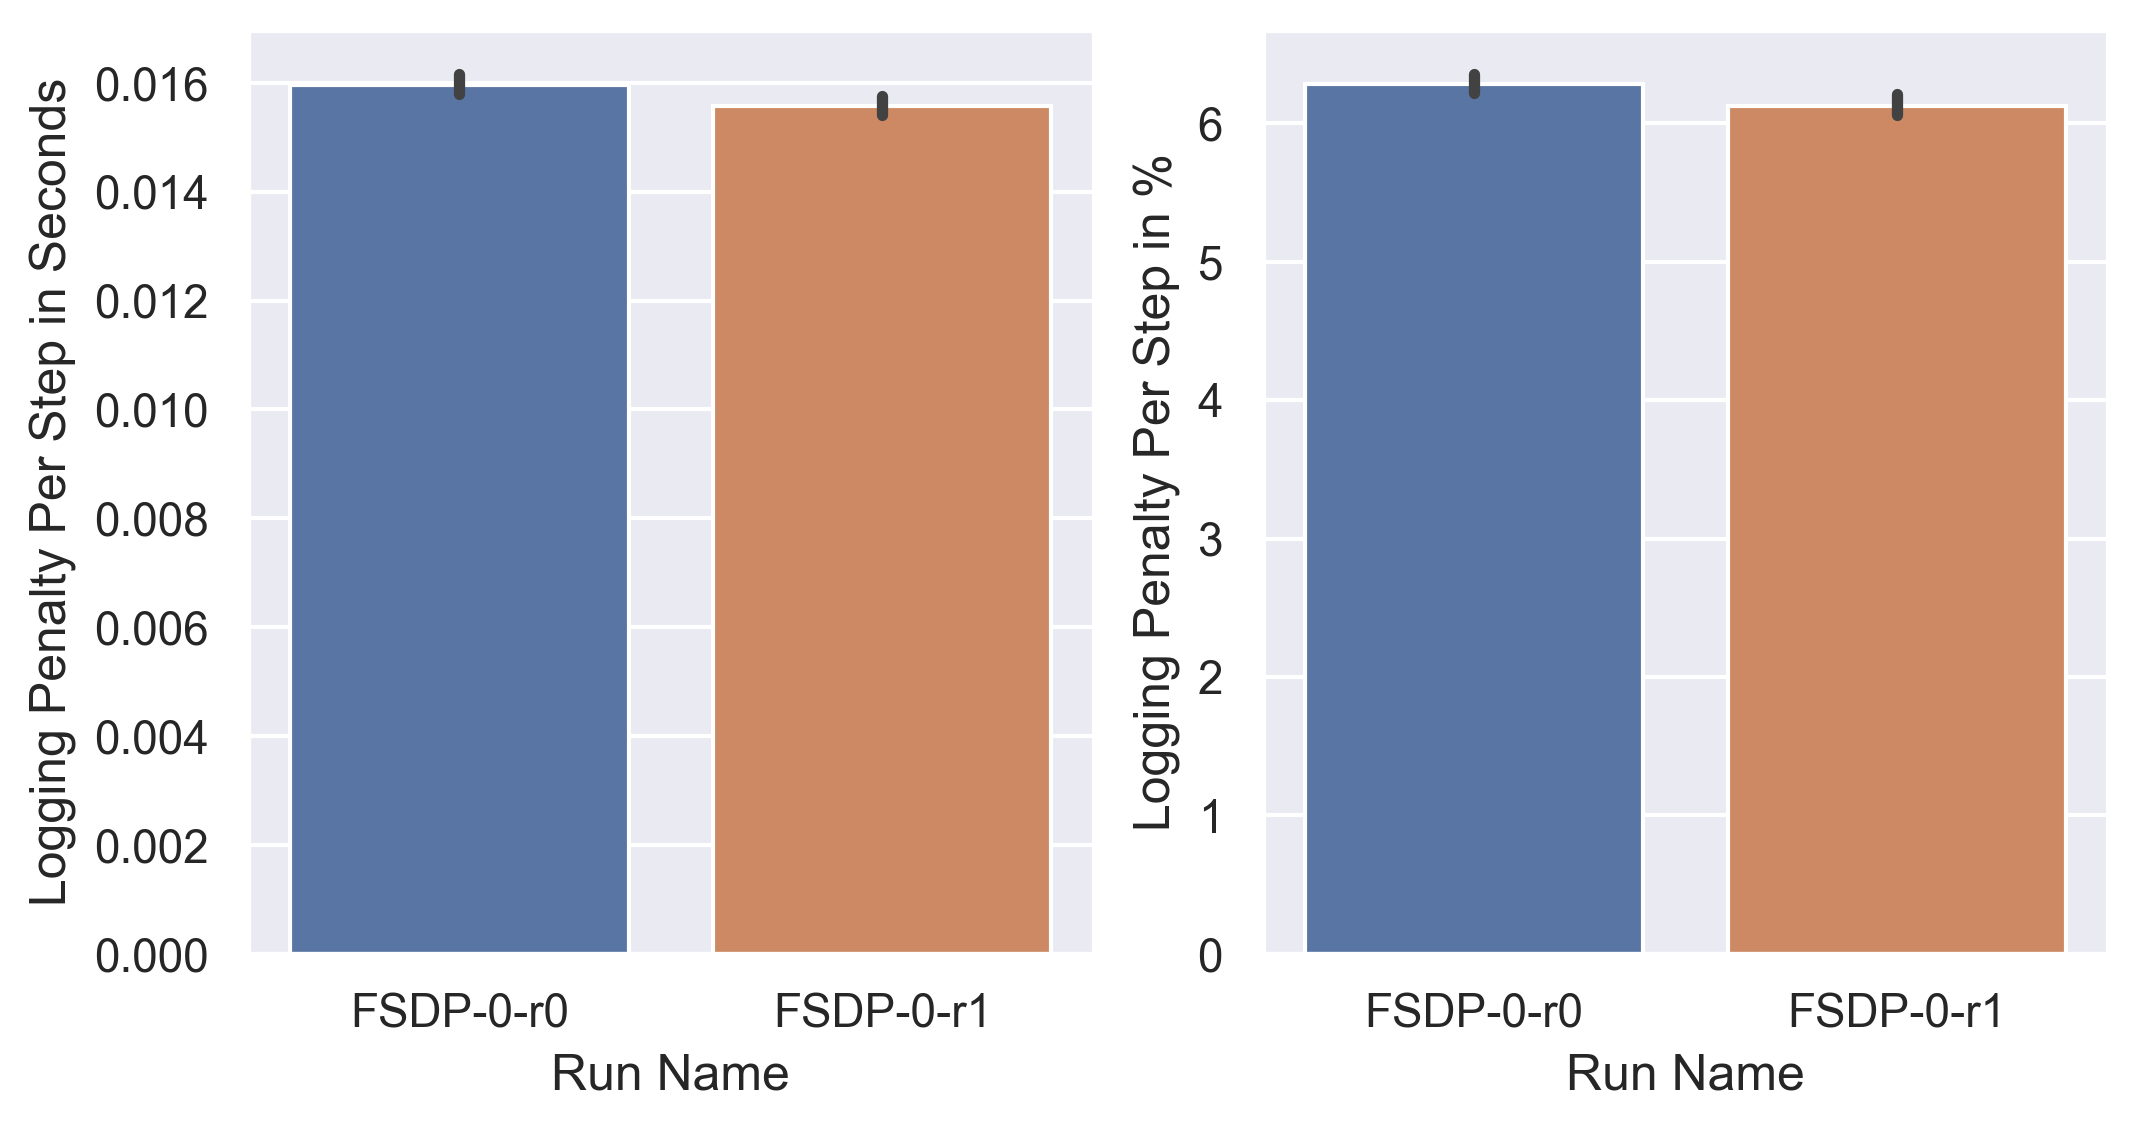

In [507]:
runs_df["logging_penalty_per_step_s"] = runs_df["02_timing/actual_step_time_s"] - runs_df["02_timing/calculated_step_time_s"]
runs_df["logging_penalty_per_step_percent"] = runs_df["logging_penalty_per_step_s"] / runs_df["02_timing/calculated_step_time_s"] * 100
fig, ax = plt.subplots(1, 2, figsize=(8,4))
fig = sns.barplot(
    data=runs_df,
    x="run_name",
    y="logging_penalty_per_step_s",
    ax=ax[0]
)
#ax[0].set_xticks(rotation=90)
ax[0].set_ylabel("Logging Penalty Per Step in Seconds")
ax[0].set_xlabel("Run Name")
fig = sns.barplot(
    data=runs_df,
    x="run_name",
    y="logging_penalty_per_step_percent",
    ax=ax[1]
)
ax[1].set_ylabel("Logging Penalty Per Step in %")
ax[1].set_xlabel("Run Name")

## All Timings Visualized

In [508]:
def set_fontsizes(small=8, medium=10, bigger=12):
    SMALL_SIZE = small
    MEDIUM_SIZE = medium
    BIGGER_SIZE = bigger

    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [509]:
temp_df = runs_df
x = "run_name"
#x = "global_rank"

Text(0.5, 0.98, 'All Timings')

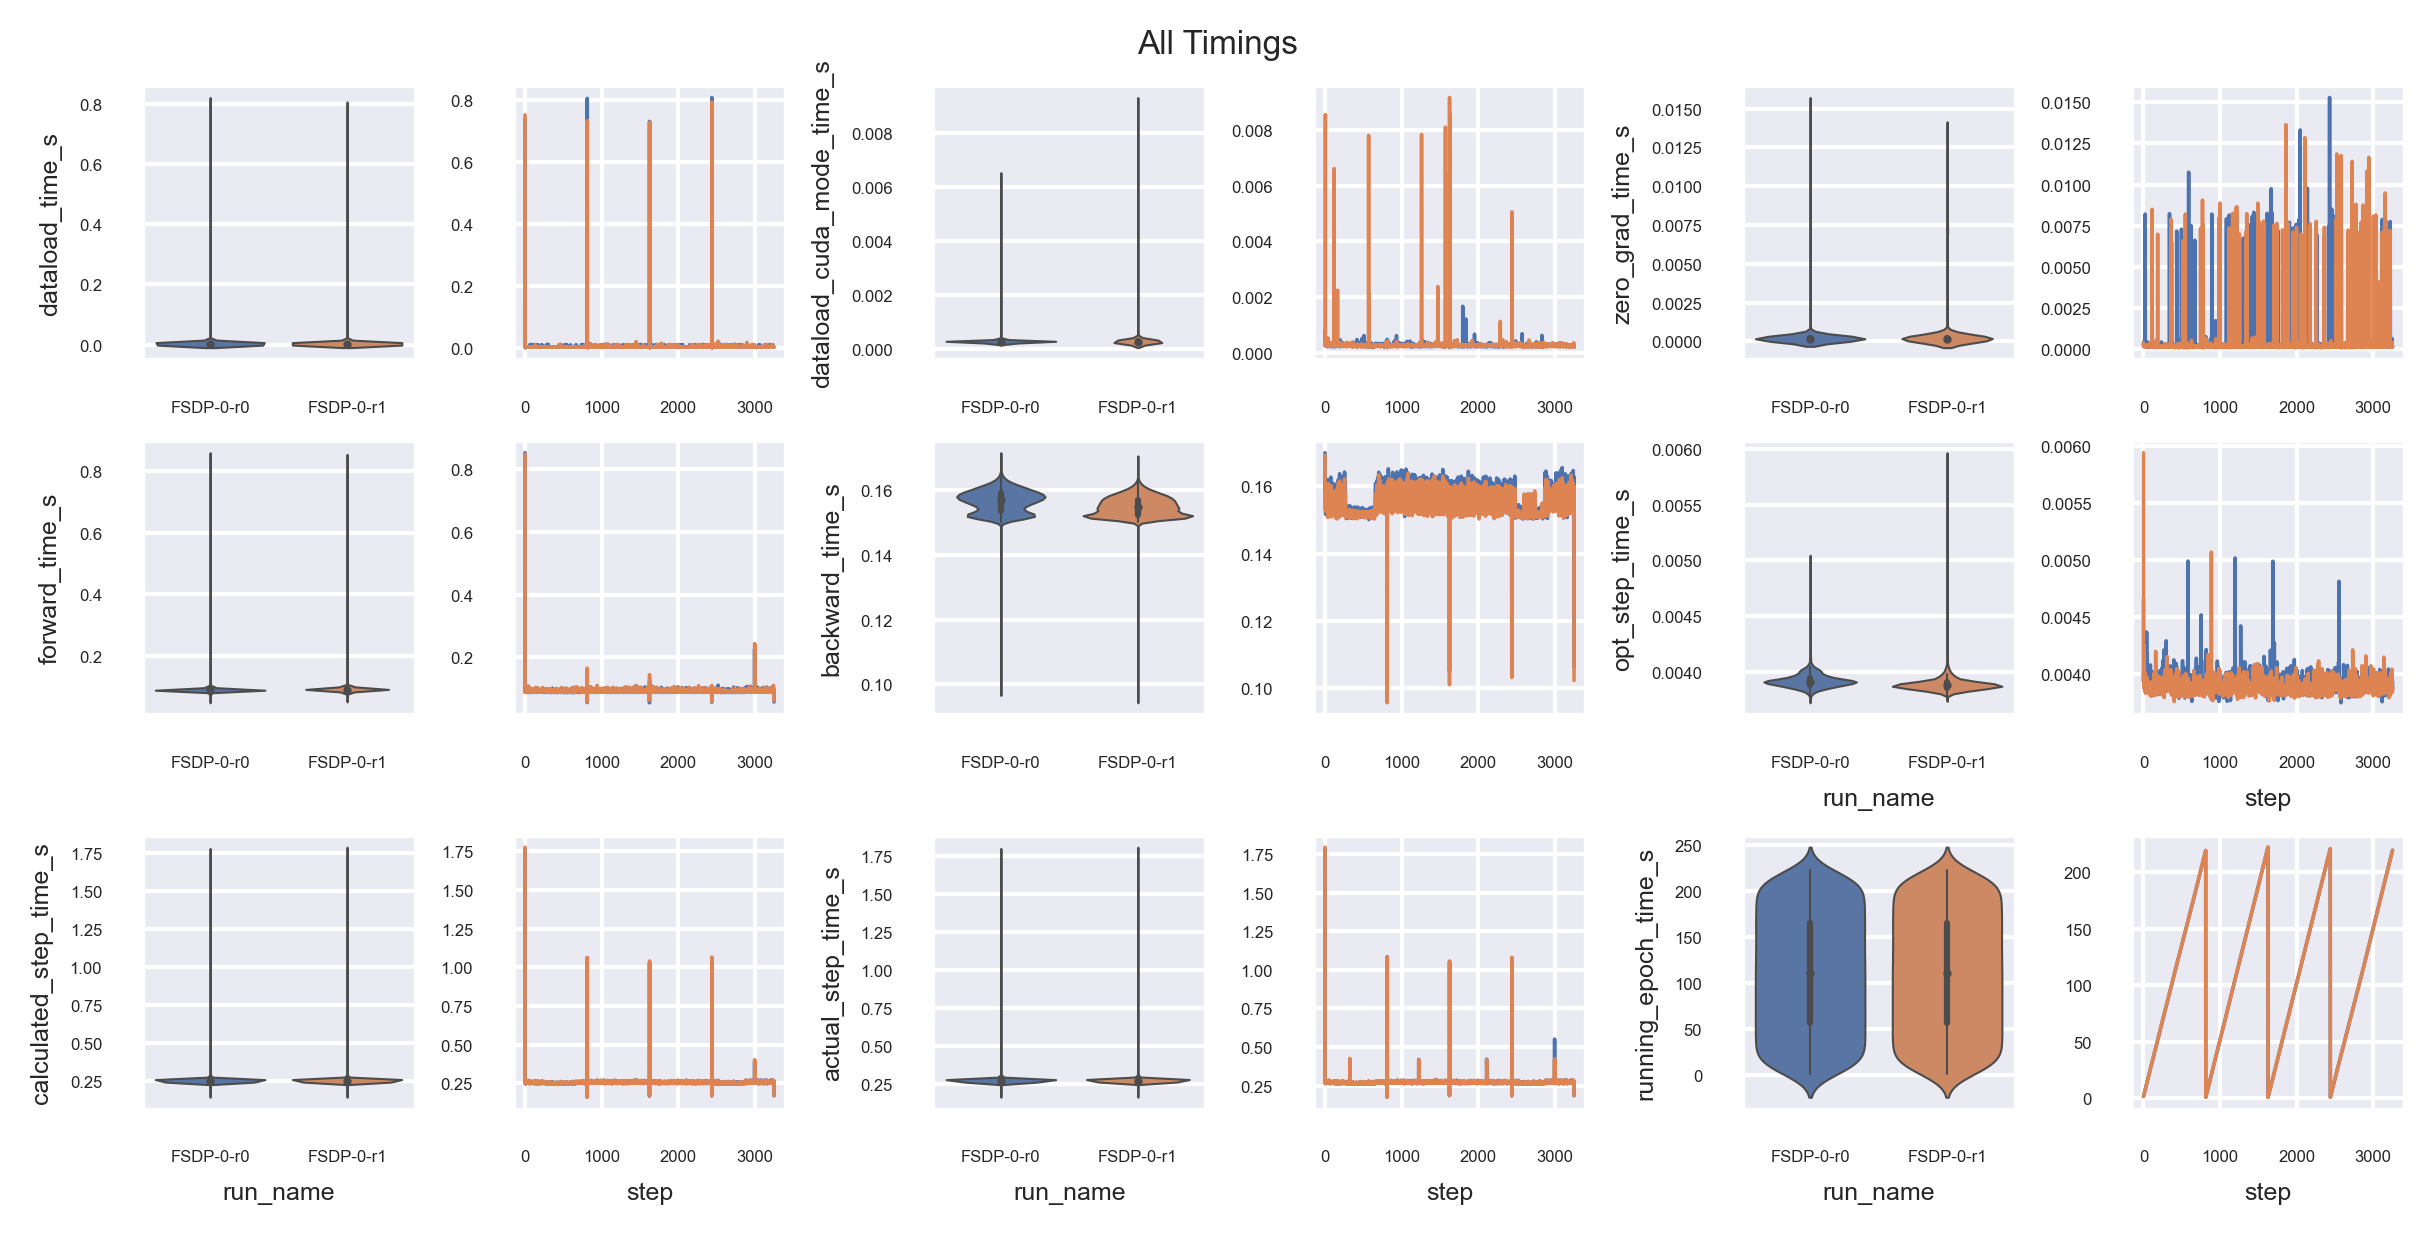

In [510]:
set_fontsizes(4,6,8)
fig, axs = plt.subplots(3, 6, figsize=(8, 4), layout='constrained')
timings = [
    "02_timing/dataload_time_s","02_timing/dataload_time_s",
    "02_timing/dataload_cuda_mode_time_s","02_timing/dataload_cuda_mode_time_s",
    "02_timing/zero_grad_time_s","02_timing/zero_grad_time_s",
    "02_timing/forward_time_s","02_timing/forward_time_s",
    "02_timing/backward_time_s","02_timing/backward_time_s",
    "02_timing/opt_step_time_s","02_timing/opt_step_time_s",
    "02_timing/calculated_step_time_s","02_timing/calculated_step_time_s",
    "02_timing/actual_step_time_s","02_timing/actual_step_time_s",
    "02_timing/running_epoch_time_s","02_timing/running_epoch_time_s"
]
timing_ax_map = list(zip(timings, axs.flat))

for (name1, ax1), (name2, ax2) in list(zip(timing_ax_map, timing_ax_map[1:]))[::2]:
    ax1 = sns.violinplot(
        data=temp_df,
        x=x,
        y=name1,
        linewidth=0.5,
        whis=0.5,
        fliersize=0.5,
        ax=ax1)
    ax1.set_ylabel(name1.replace("02_timing/", ""))
    ax2 = sns.lineplot(
        data=temp_df,
        x="step",
        y=name2,
        ax=ax2,
        hue=x,
        linewidth=0.85)
    ax2.get_legend().remove()
    ax2.set_ylabel("")
    if not ("step" in name1 or "epoch" in name1):
        ax1.set_xlabel("")
        ax2.set_xlabel("")

fig.suptitle("All Timings")

## Selective Metrics View

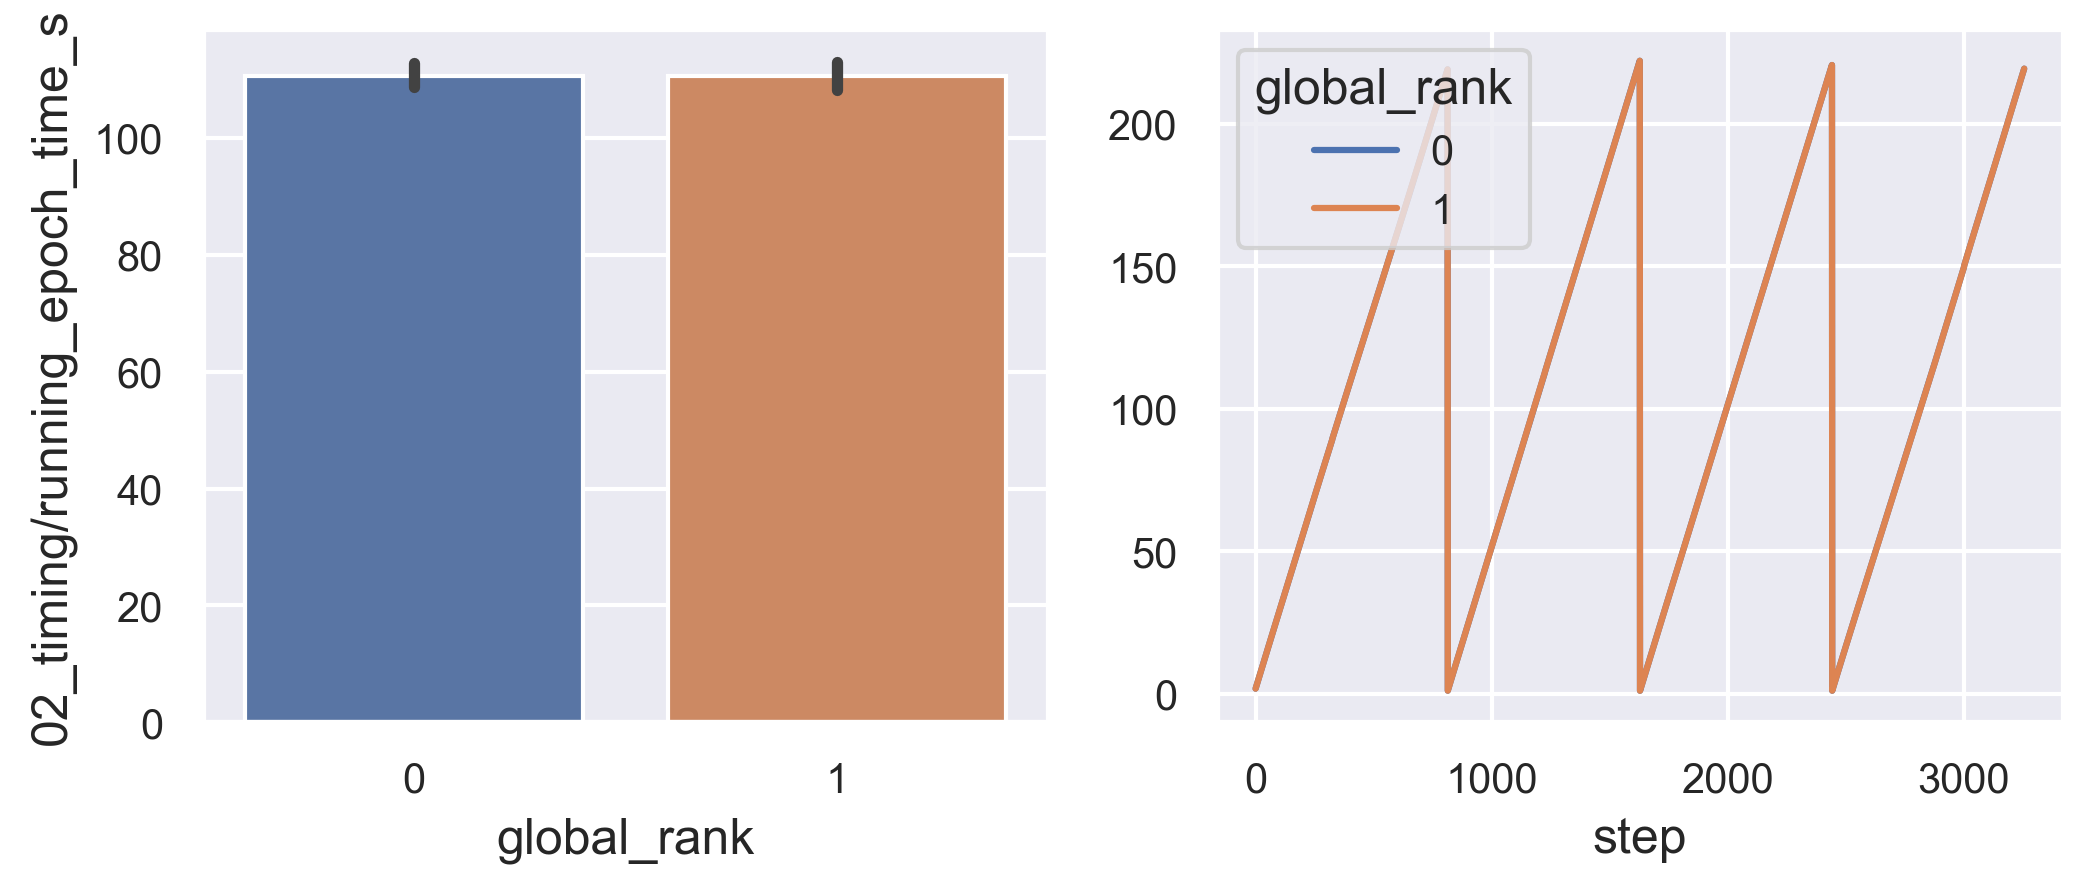

In [511]:
set_fontsizes(10,12,14)

def dual_plot(df, x, y, line_ylim=None, figsize=(8,3), title=None):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=figsize)
    ax1 = sns.barplot(
        data=df,
        x=x,
        y=y,
        ax=ax1)
    ax2 = sns.lineplot(
        data=df,
        x="step",
        y=y,
        ax=ax2,
        hue=x)
    ax2.set_ylabel("")
    ax2.set_ylim(line_ylim)
    if title != None:
        fig.suptitle(title, fontsize=16)
    
test_run = runs_df.query("group_name=='FSDP-0'")
x = "global_rank"
y = "02_timing/running_epoch_time_s"
dual_plot(df=test_run, x=x, y=y)#, line_ylim=[0,0.5])

## Comparing Epoch Time

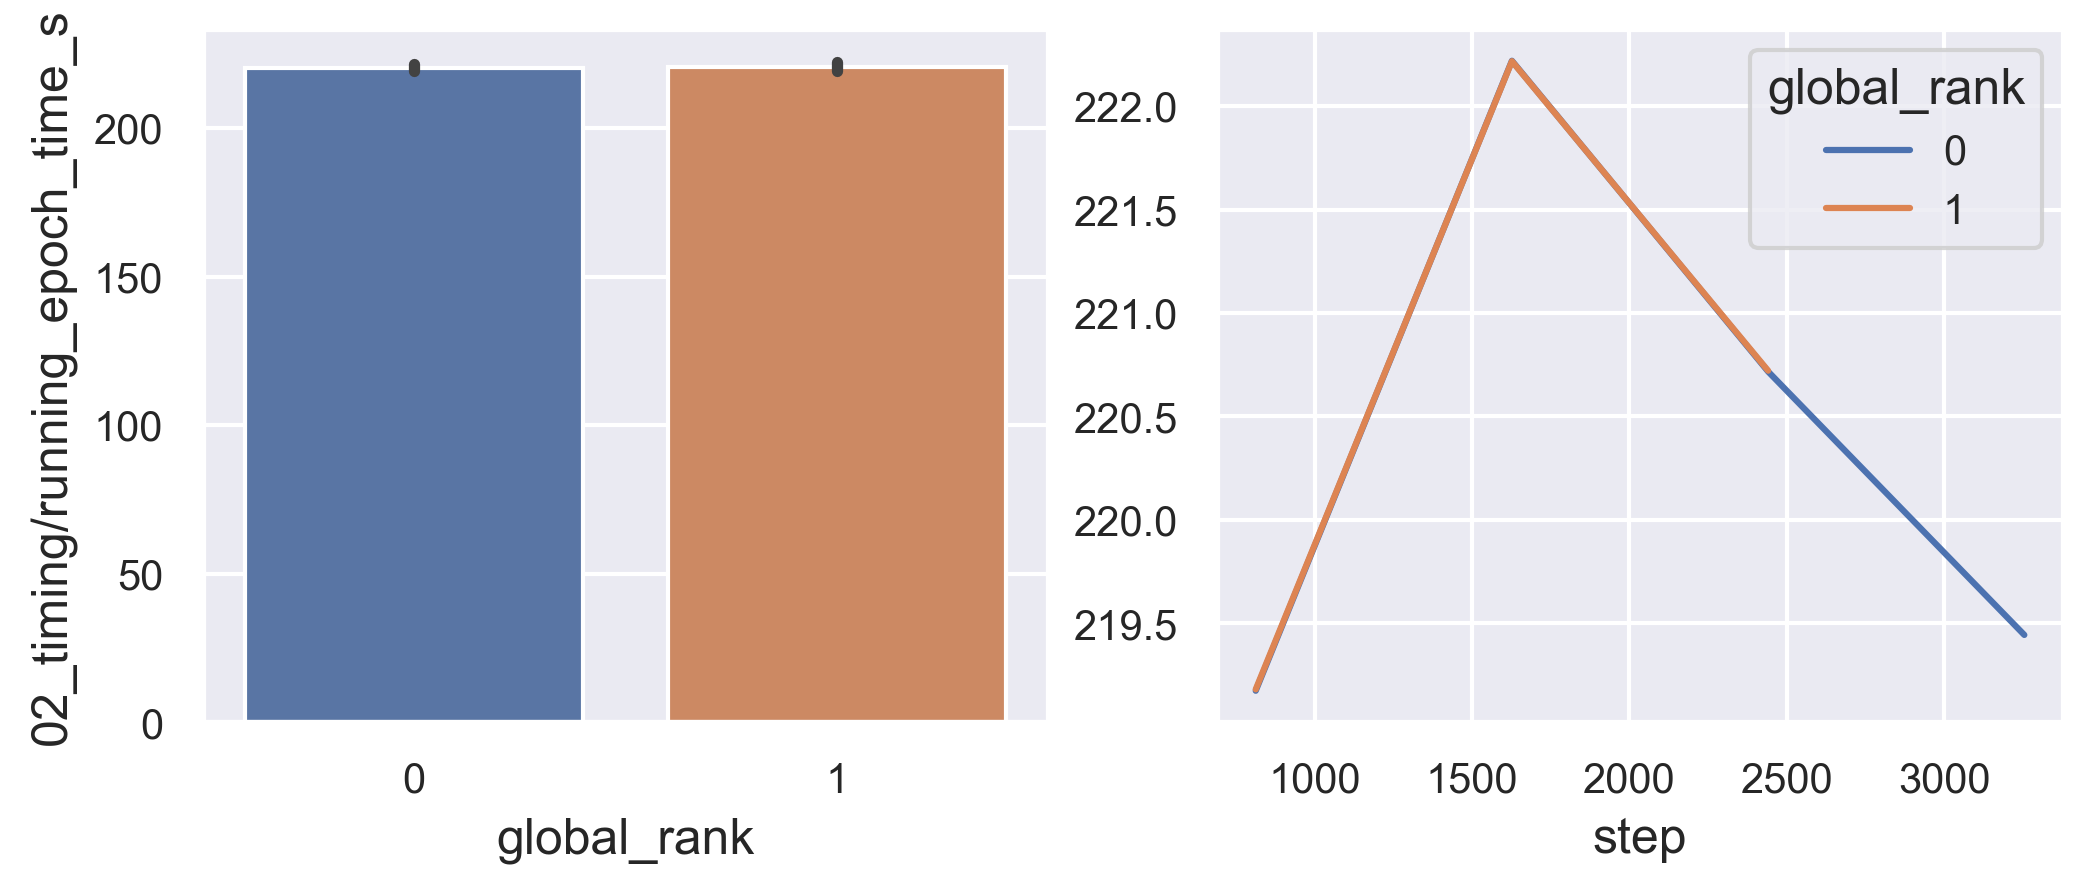

In [520]:
temp_df = runs_df

epoch_timing_df = temp_df.loc[temp_df[temp_df["01_general/step"].diff()<0].index - 1]
x = "global_rank"
y = "02_timing/running_epoch_time_s"
dual_plot(df=epoch_timing_df, x=x, y=y)

##  Step Timing Of All Runs

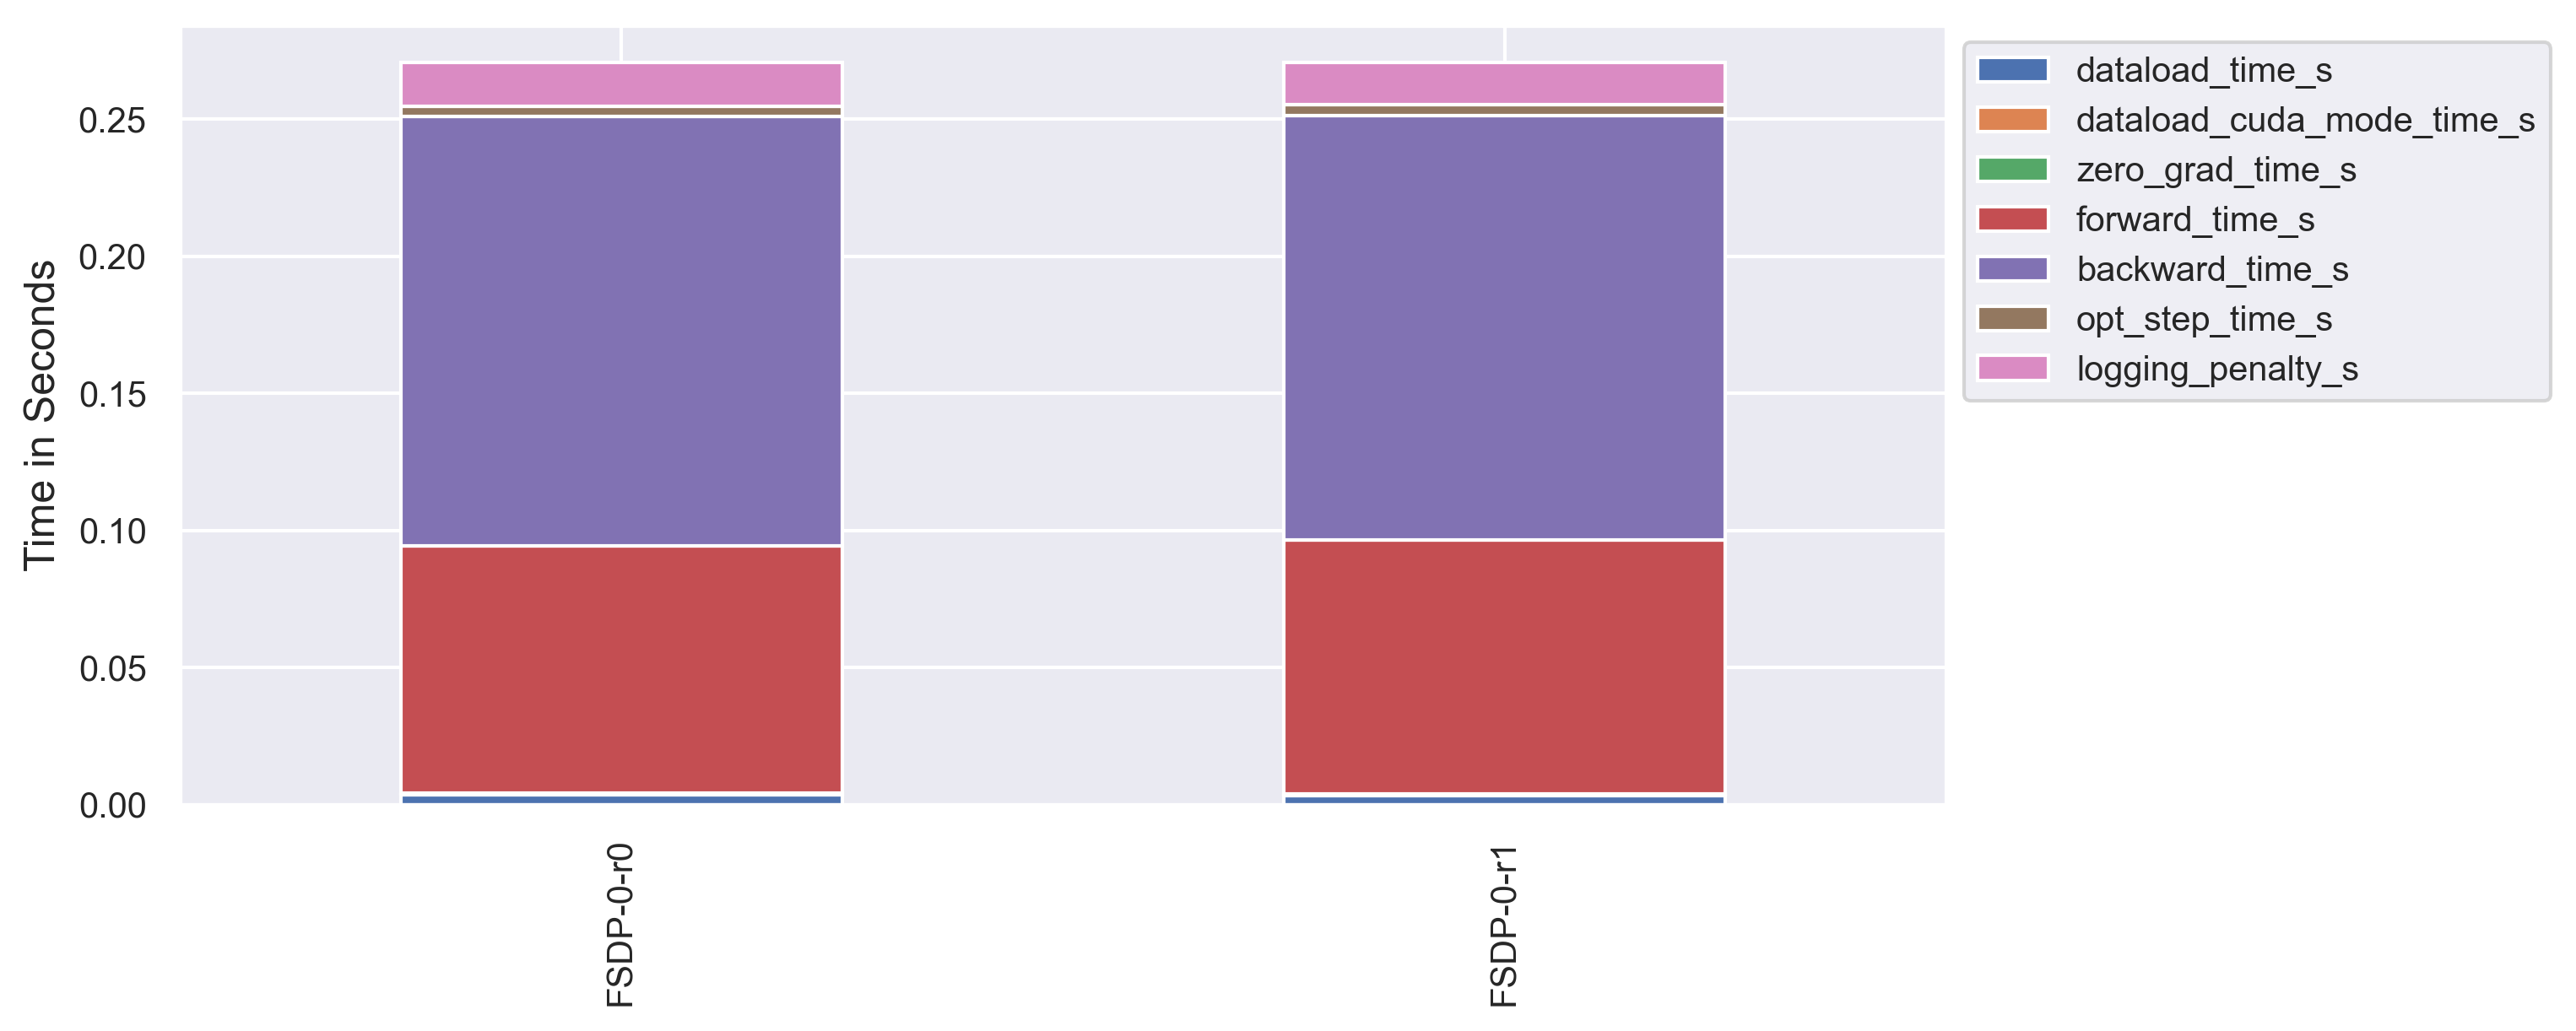

In [428]:
set_fontsizes(10,12,14)

def get_average_step_timings(df):
    mean_df = df.mean(numeric_only=True).to_frame().T
    mean_df["run_name"] = df["run_name"].unique()[0]
    mean_df = mean_df.rename(columns={
                            "02_timing/dataload_time_s": "dataload_time_s",
                            "02_timing/dataload_cuda_mode_time_s": "dataload_cuda_mode_time_s",
                            "02_timing/zero_grad_time_s": "zero_grad_time_s",
                            "02_timing/forward_time_s": "forward_time_s",
                            "02_timing/backward_time_s": "backward_time_s",
                            "02_timing/opt_step_time_s": "opt_step_time_s",
                            "logging_penalty_per_step_s": "logging_penalty_s"
                            })
    
    exported_labels = [
        "dataload_time_s",
        "dataload_cuda_mode_time_s",
        "zero_grad_time_s",
        "forward_time_s",
        "backward_time_s",
        "opt_step_time_s",
        "logging_penalty_s",
        "run_name"]
    return mean_df[exported_labels], exported_labels

timings = []

for run_name in runs_df["run_name"].unique():
    single_run = runs_df.query(f"run_name=='{run_name}'")
    avg_step_timing_df, exported_labels = get_average_step_timings(df=single_run)
    timings.append(avg_step_timing_df)

all_step_timings_df = pd.concat(objs=timings)
ax = all_step_timings_df[exported_labels].set_index("run_name").plot(kind="bar", stacked=True, figsize=(9,4))
plt.ylabel("Time in Seconds")
plt.xlabel("")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1,1))

## Epoch + Training Time For All Runs

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))
fig = sns.barplot(
    data=runs_df,
    x="run_name",
    y="logging_penalty_per_step_s",
    ax=ax[0]
)
#ax[0].set_xticks(rotation=90)
ax[0].set_ylabel("Logging Penalty Per Step in Seconds")
ax[0].set_xlabel("Run Name")
fig = sns.barplot(
    data=runs_df,
    x="run_name",
    y="logging_penalty_per_step_percent",
    ax=ax[1]
)
ax[1].set_ylabel("Logging Penalty Per Step in %")
ax[1].set_xlabel("Run Name")

<Axes: xlabel='step', ylabel='02_timing/running_training_time_s'>

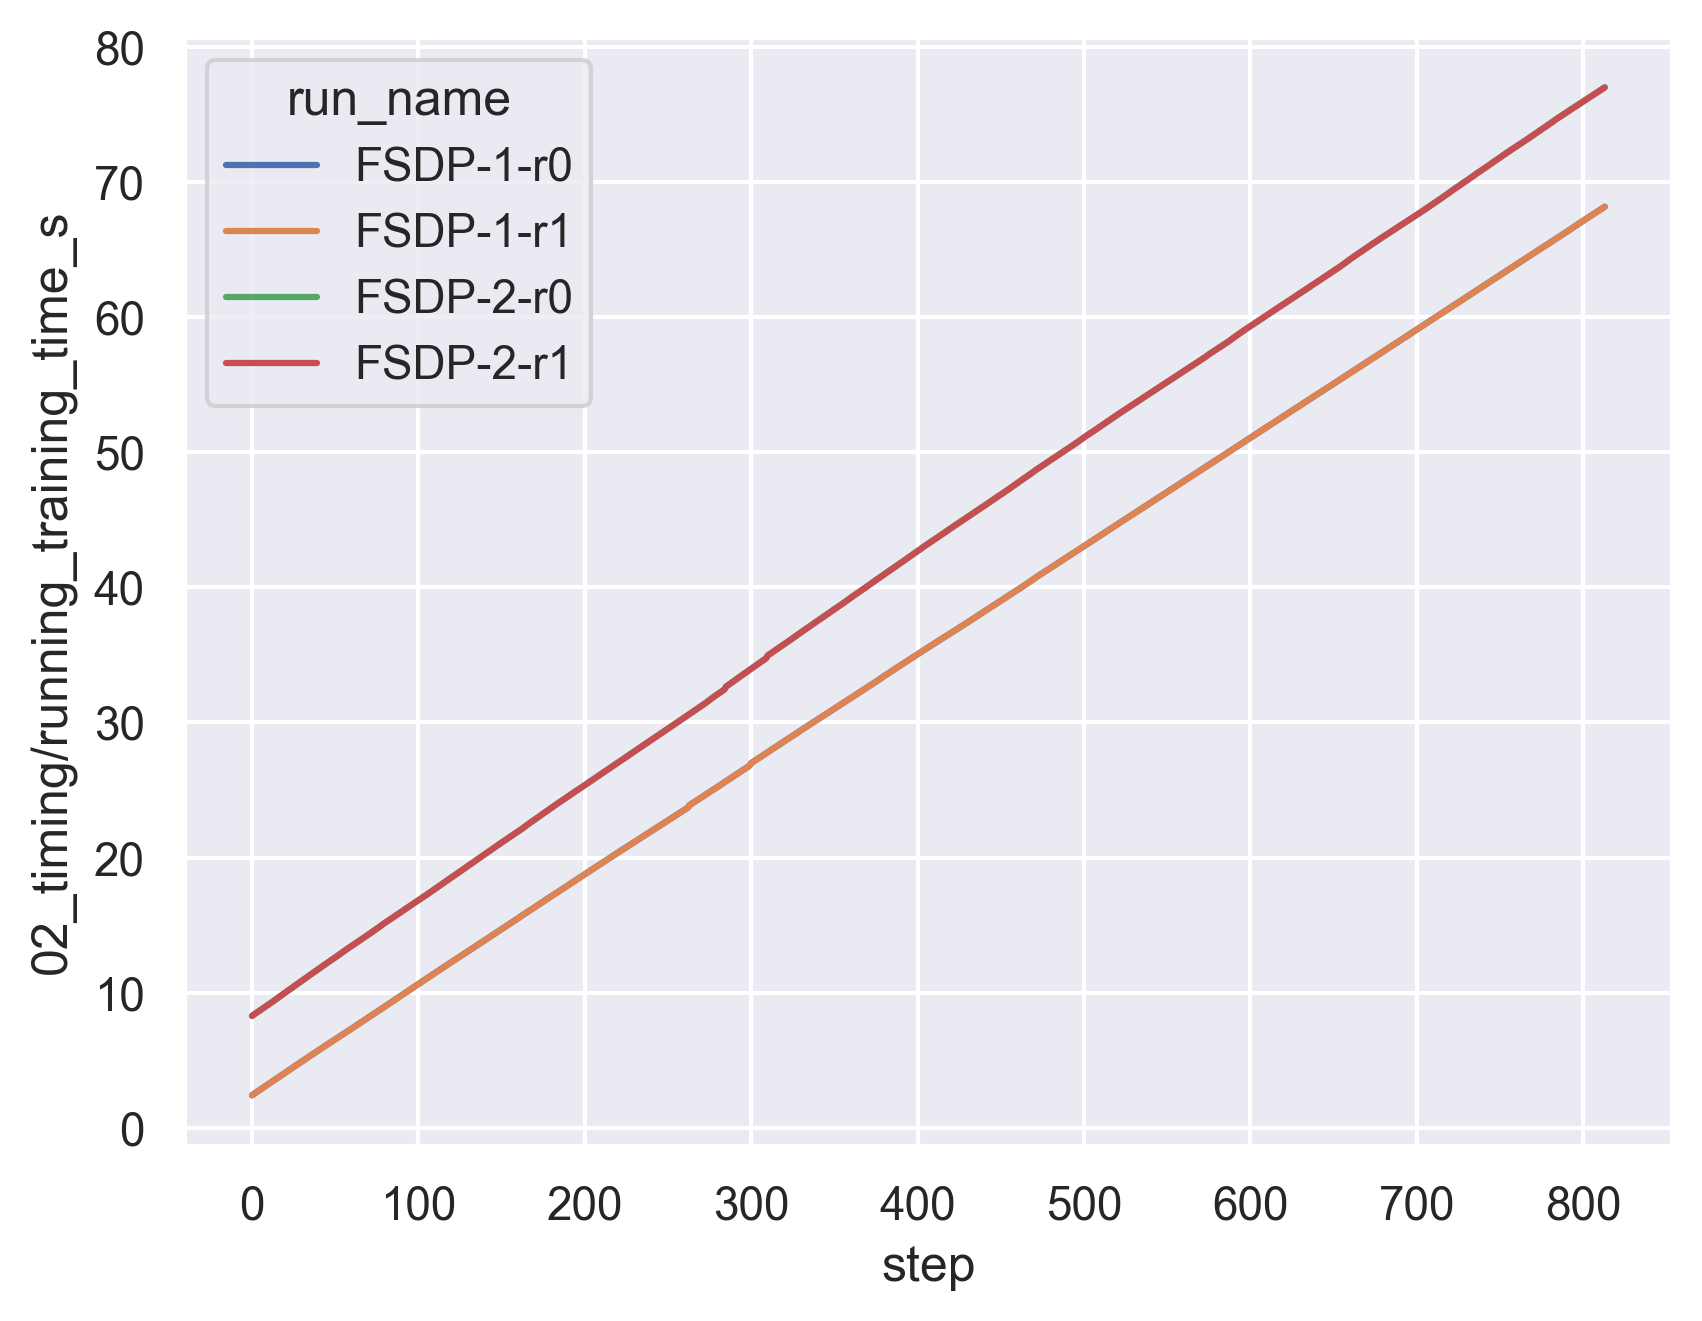

In [296]:
runs_df[['02_timing/running_epoch_time_s', "run_name", "step"]].query("run_name=='FSDP-1-r0'") #, '02_timing/running_training_time_s'

sns.lineplot(data=runs_df, x="step", y="02_timing/running_training_time_s", hue="run_name")

## GPU Memory Statistics

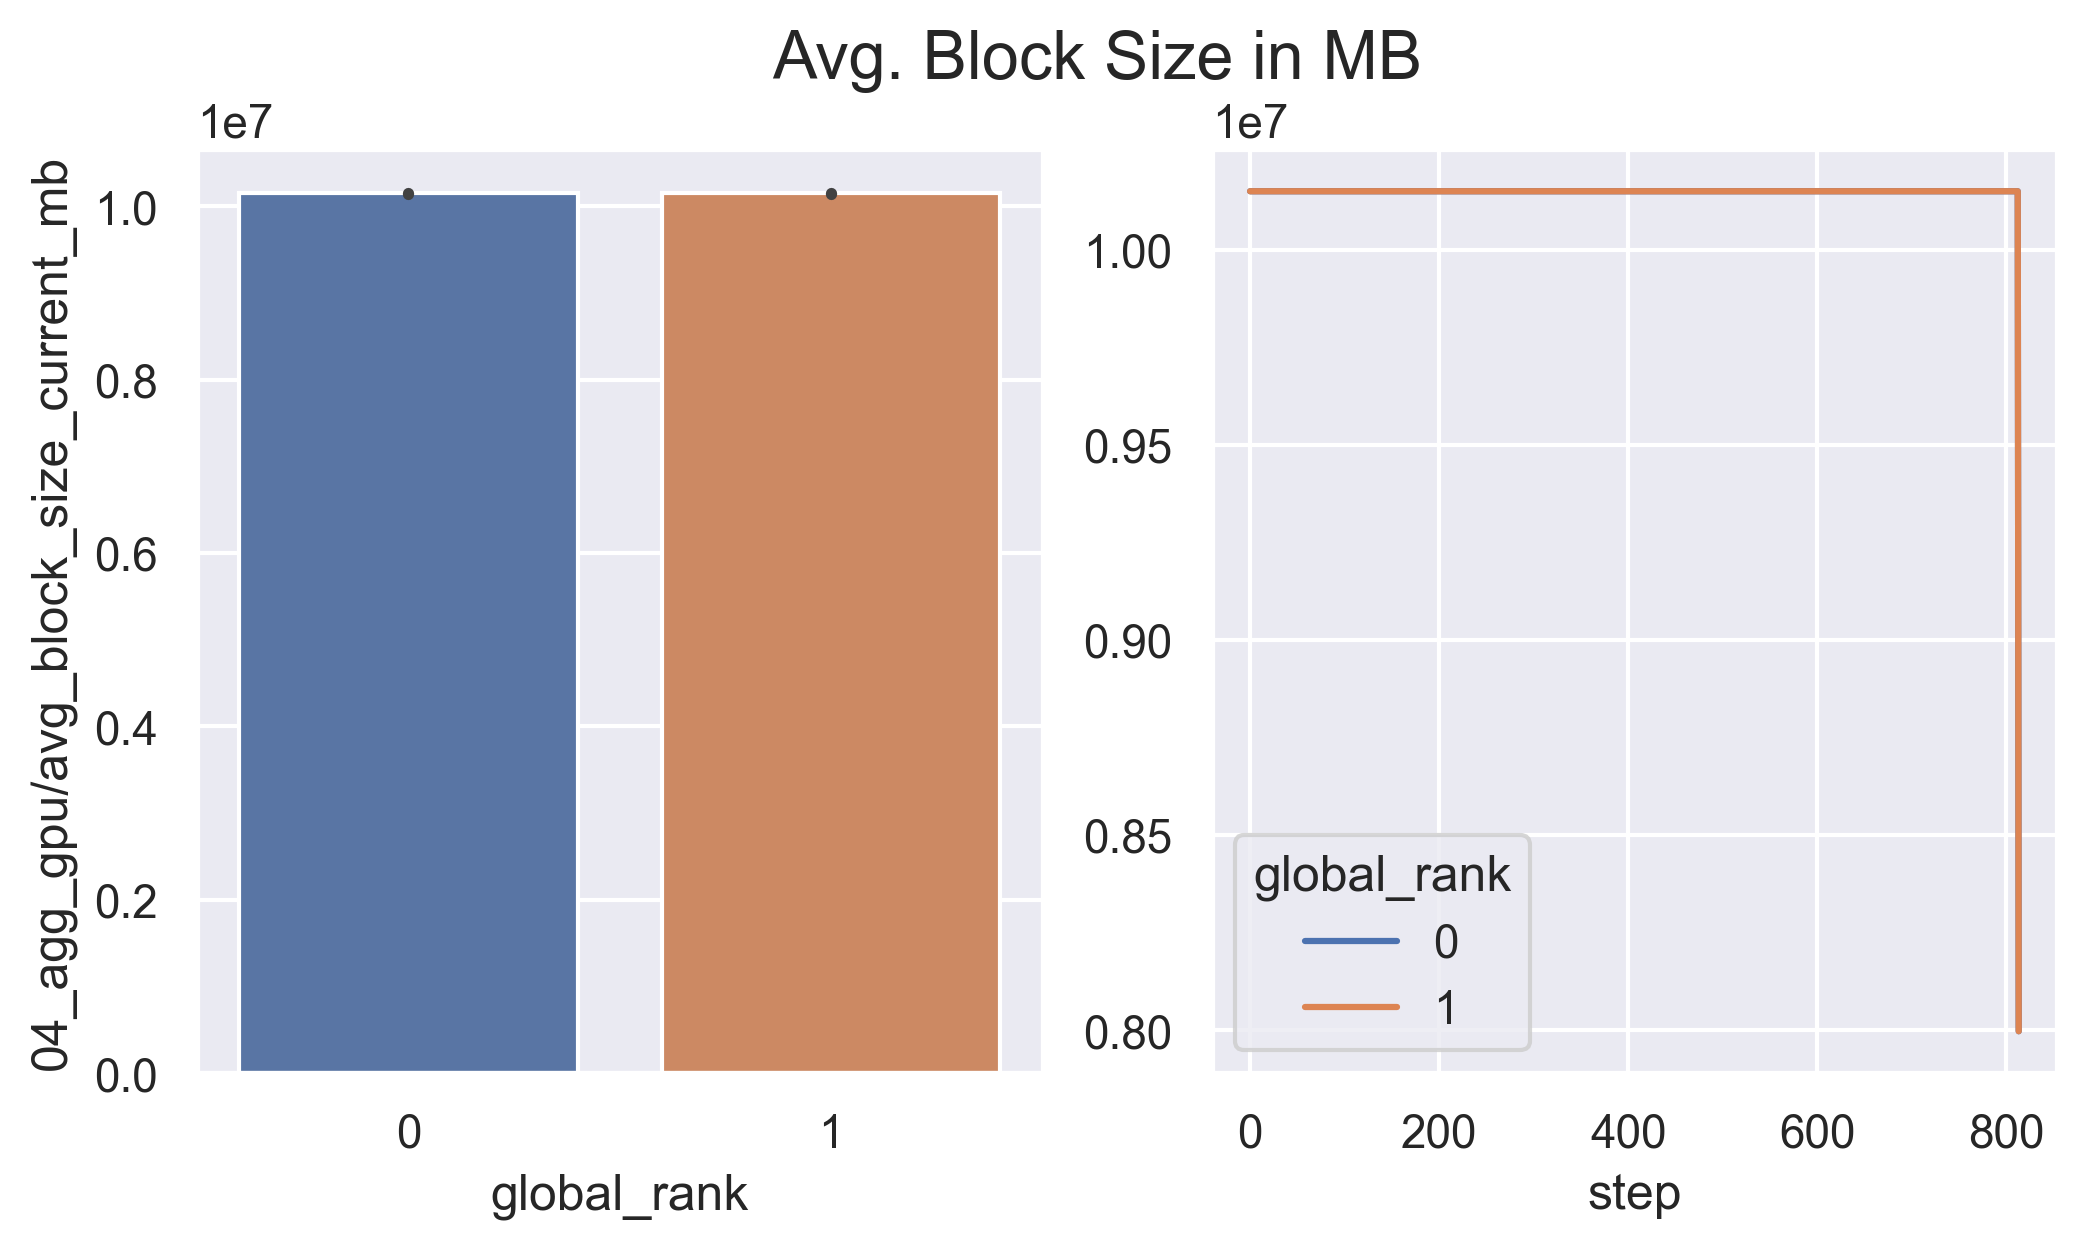

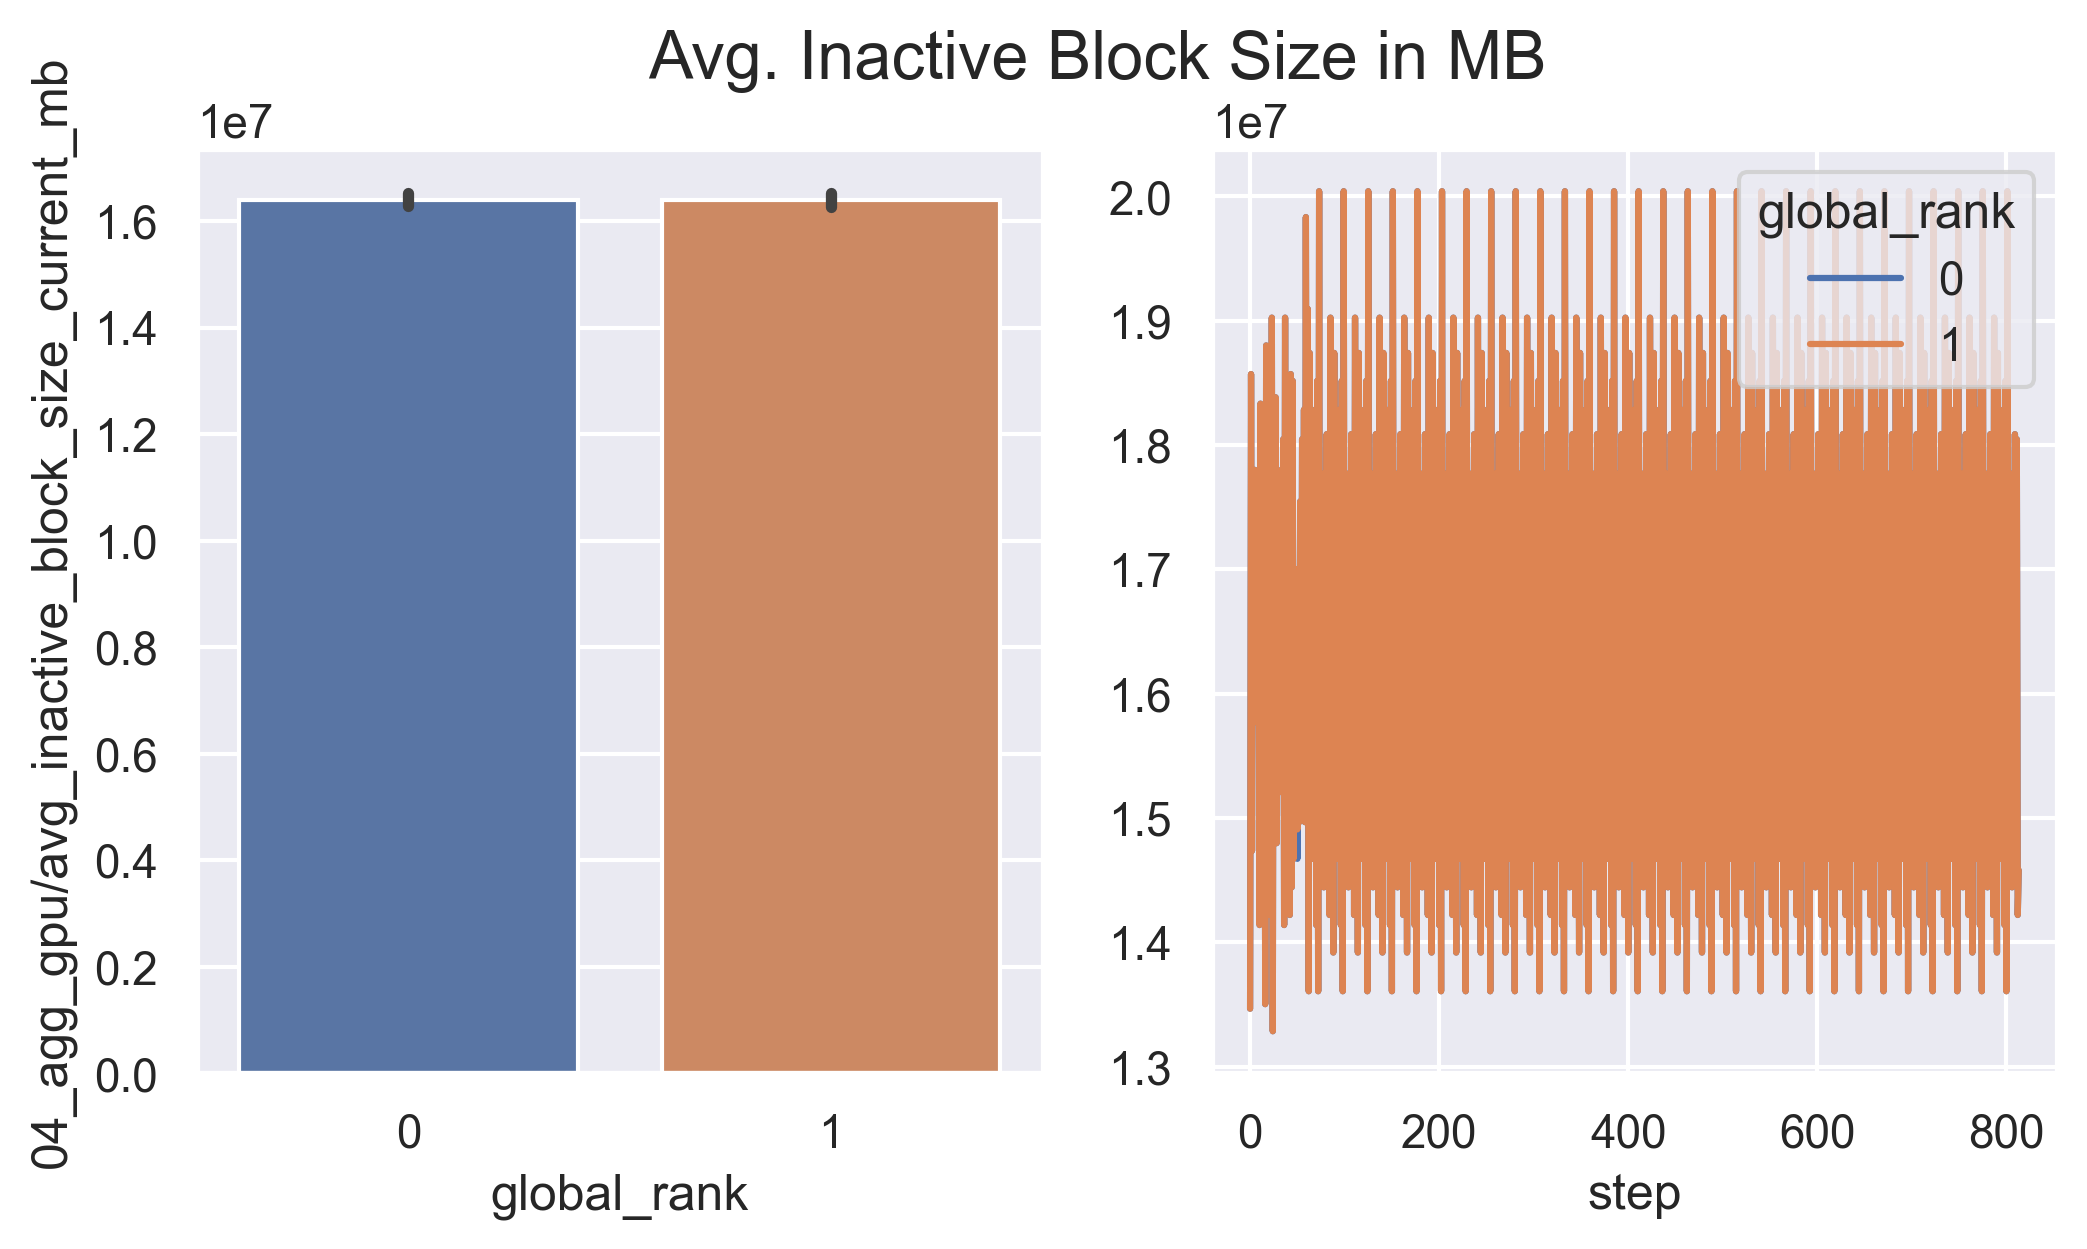

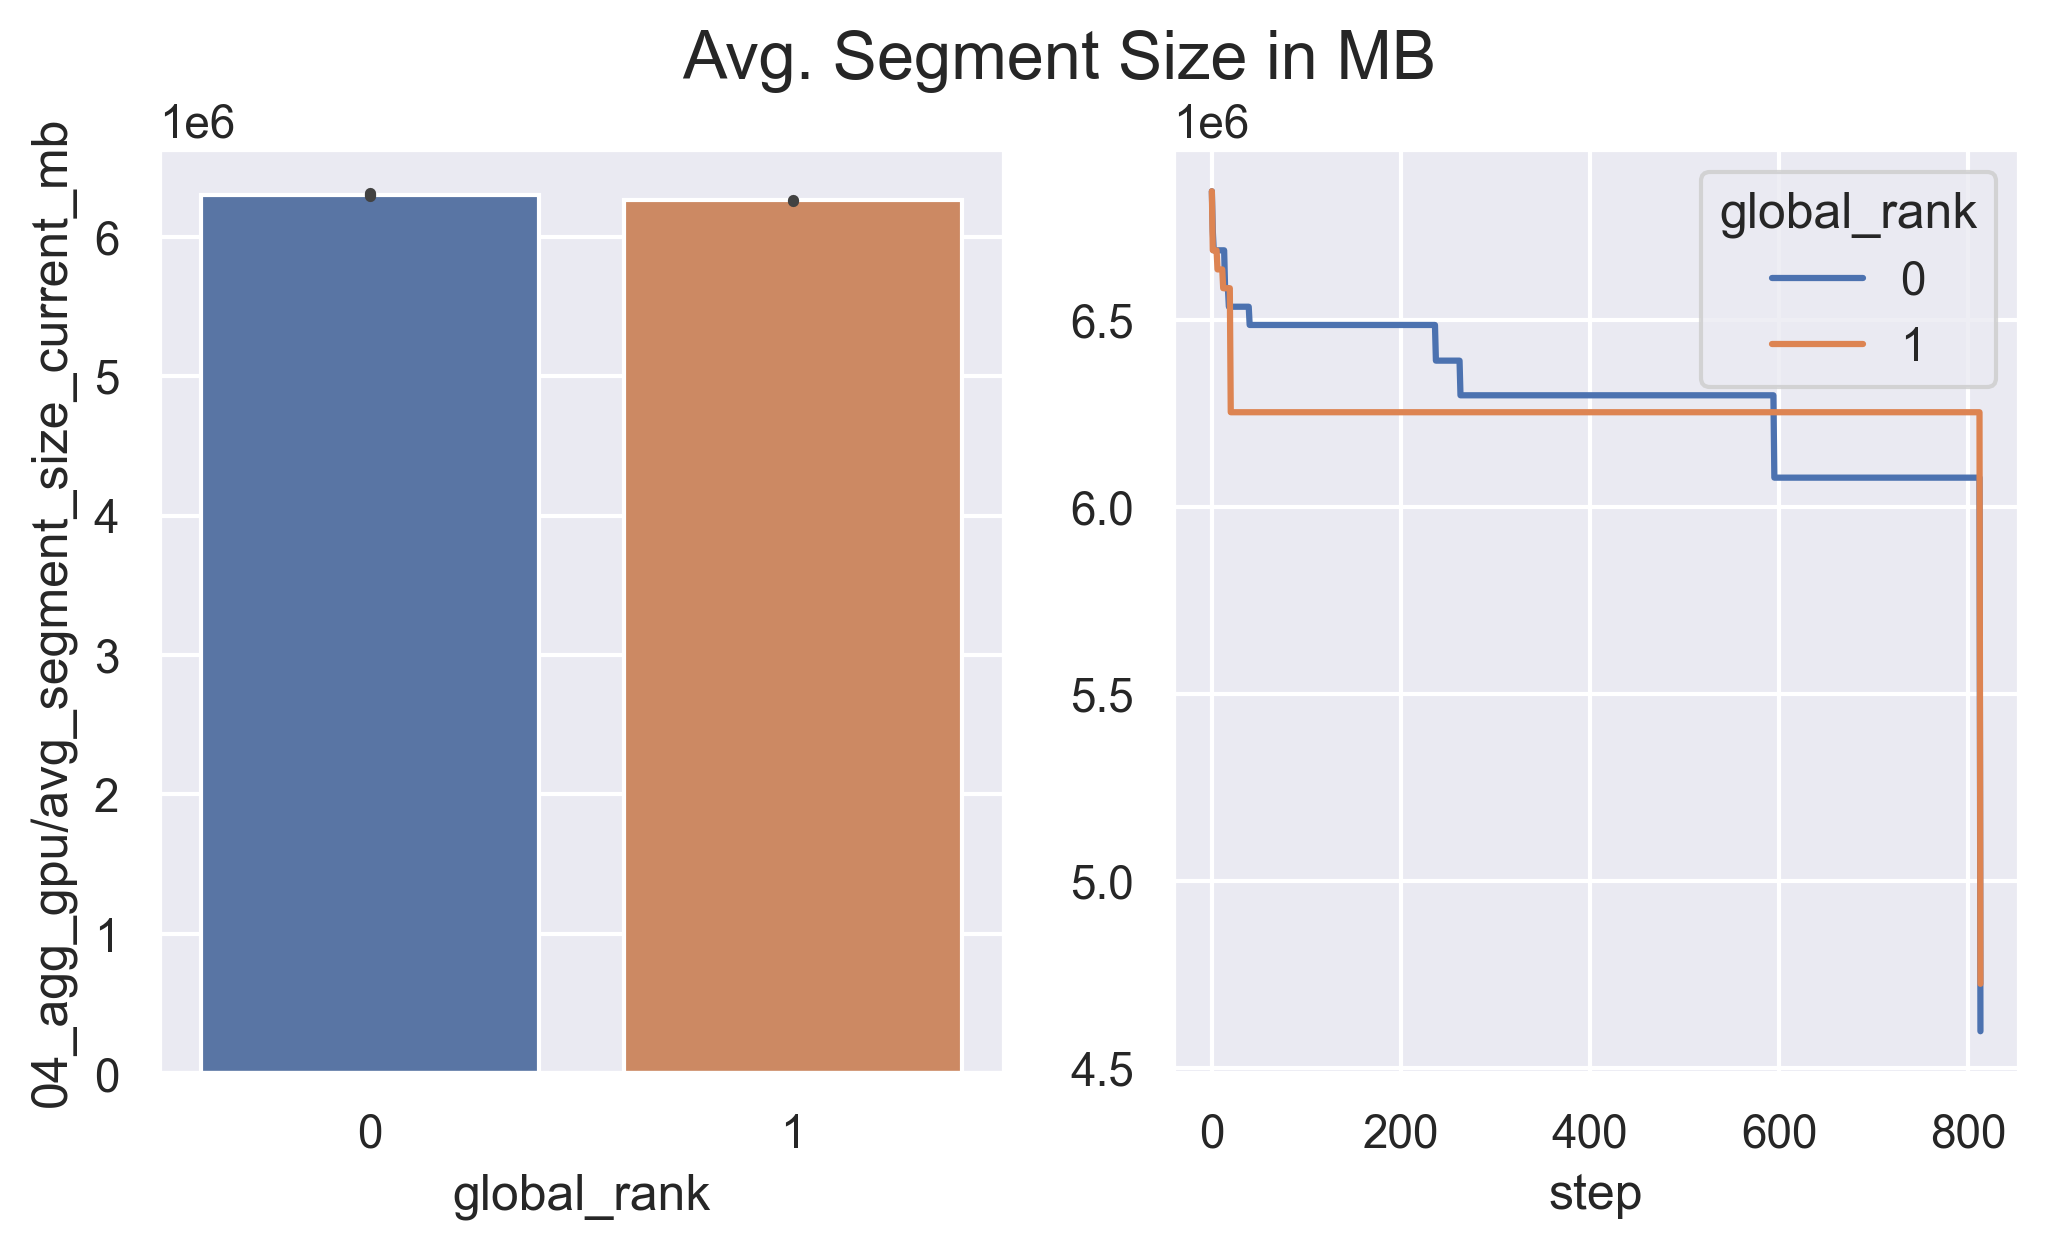

In [354]:


# 04_agg_gpu/avg_block_size_current_mb
# 04_agg_gpu/avg_inactive_block_size_current_mb
# 04_agg_gpu/avg_segment_size_current_mb
test_run = runs_df.query("group_name=='FSDP-8'")
x = "global_rank"
y = "04_agg_gpu/avg_block_size_current_mb"
dual_plot(df=test_run, x=x, y=y, figsize=(8,4), title="Avg. Block Size in MB")
y = "04_agg_gpu/avg_inactive_block_size_current_mb"
dual_plot(df=test_run, x=x, y=y, figsize=(8,4), title="Avg. Inactive Block Size in MB")
y = "04_agg_gpu/avg_segment_size_current_mb"
dual_plot(df=test_run, x=x, y=y, figsize=(8,4), title="Avg. Segment Size in MB")

In [ ]:
fig, axs = plt.subplots(3, 5, figsize=(8, 5), layout='constrained',
                        sharex=True, sharey=True)

fname = get_sample_data('percent_bachelors_degrees_women_usa.csv',
                        asfileobj=False)
gender_degree_data = np.genfromtxt(fname, delimiter=',', names=True)

majors = ['Health Professions', 'Public Administration', 'Education',
          'Psychology', 'Foreign Languages', 'English',
          'Art and Performance', 'Biology',
          'Agriculture', 'Business',
          'Math and Statistics', 'Architecture', 'Physical Sciences',
          'Computer Science', 'Engineering']

for nn, ax in enumerate(axs.flat):
    ax.set_xlim(1969.5, 2011.1)
    column = majors[nn]
    column_rec_name = column.replace('\n', '_').replace(' ', '_')

    line, = ax.plot('Year', column_rec_name, data=gender_degree_data,
                    lw=2.5)
    ax.set_title(column, fontsize='small', loc='left')
    ax.set_ylim([0, 100])
    ax.grid()
fig.supxlabel('Year')
fig.supylabel('Percent Degrees Awarded To Women')

plt.show()

In [355]:
# active
# active mb
# allocated
# allocated mb
# inactive split
# inactive split mb
# requested mb
# reserved mb
# segment

# 03_gpu/oversize_allocations
# 03_gpu/oversize_segments

# 03_gpu/max_split_size
# 03_gpu/num_alloc_retries
# 03_gpu/num_ooms
# 04_agg_gpu/avg_block_size_current_mb
# 04_agg_gpu/avg_inactive_block_size_current_mb
# 04_agg_gpu/avg_segment_size_current_mb
"""
03_gpu/active.all.current
03_gpu/active.all.freed
03_gpu/active.all.peak
03_gpu/active.large_pool.current
03_gpu/active.large_pool.freed
03_gpu/active.large_pool.peak
03_gpu/active.small_pool.current
03_gpu/active.small_pool.freed
03_gpu/active.small_pool.peak
03_gpu/active_mb.all.allocated
03_gpu/active_mb.all.current
03_gpu/active_mb.all.freed
03_gpu/active_mb.all.peak
03_gpu/active_mb.large_pool.allocated
03_gpu/active_mb.large_pool.current
03_gpu/active_mb.large_pool.freed
03_gpu/active_mb.large_pool.peak
03_gpu/active_mb.small_pool.allocated
03_gpu/active_mb.small_pool.current
03_gpu/active_mb.small_pool.freed
03_gpu/active_mb.small_pool.peak
03_gpu/allocated_mb.all.allocated
03_gpu/allocated_mb.all.current
03_gpu/allocated_mb.all.freed
03_gpu/allocated_mb.all.peak
03_gpu/allocated_mb.large_pool.allocated
03_gpu/allocated_mb.large_pool.current
03_gpu/allocated_mb.large_pool.freed
03_gpu/allocated_mb.large_pool.peak
03_gpu/allocated_mb.small_pool.allocated
03_gpu/allocated_mb.small_pool.current
03_gpu/allocated_mb.small_pool.freed
03_gpu/allocated_mb.small_pool.peak
03_gpu/allocation.all.current
03_gpu/allocation.all.freed
03_gpu/allocation.all.peak
03_gpu/allocation.large_pool.current
03_gpu/allocation.large_pool.freed
03_gpu/allocation.large_pool.peak
03_gpu/allocation.small_pool.current
03_gpu/allocation.small_pool.freed
03_gpu/allocation.small_pool.peak
03_gpu/inactive_split.all.current
03_gpu/inactive_split.all.freed
03_gpu/inactive_split.all.peak
03_gpu/inactive_split.large_pool.current
03_gpu/inactive_split.large_pool.freed
03_gpu/inactive_split.large_pool.peak
03_gpu/inactive_split.small_pool.current
03_gpu/inactive_split.small_pool.freed
03_gpu/inactive_split.small_pool.peak
03_gpu/inactive_split_mb.all.allocated
03_gpu/inactive_split_mb.all.current
03_gpu/inactive_split_mb.all.freed
03_gpu/inactive_split_mb.all.peak
03_gpu/inactive_split_mb.large_pool.allocated
03_gpu/inactive_split_mb.large_pool.current
03_gpu/inactive_split_mb.large_pool.freed
03_gpu/inactive_split_mb.large_pool.peak
03_gpu/inactive_split_mb.small_pool.allocated
03_gpu/inactive_split_mb.small_pool.current
03_gpu/inactive_split_mb.small_pool.freed
03_gpu/inactive_split_mb.small_pool.peak
03_gpu/max_split_size
03_gpu/num_alloc_retries
03_gpu/num_ooms
03_gpu/oversize_allocations.current
03_gpu/oversize_allocations.freed
03_gpu/oversize_allocations.peak
03_gpu/oversize_segments.current
03_gpu/oversize_segments.freed
03_gpu/oversize_segments.peak
03_gpu/requested_mb.all.allocated
03_gpu/requested_mb.all.current
03_gpu/requested_mb.all.freed
03_gpu/requested_mb.all.peak
03_gpu/requested_mb.large_pool.allocated
03_gpu/requested_mb.large_pool.current
03_gpu/requested_mb.large_pool.freed
03_gpu/requested_mb.large_pool.peak
03_gpu/requested_mb.small_pool.allocated
03_gpu/requested_mb.small_pool.current
03_gpu/requested_mb.small_pool.freed
03_gpu/requested_mb.small_pool.peak
03_gpu/reserved_mb.all.allocated
03_gpu/reserved_mb.all.current
03_gpu/reserved_mb.all.freed
03_gpu/reserved_mb.all.peak
03_gpu/reserved_mb.large_pool.allocated
03_gpu/reserved_mb.large_pool.current
03_gpu/reserved_mb.large_pool.freed
03_gpu/reserved_mb.large_pool.peak
03_gpu/reserved_mb.small_pool.allocated
03_gpu/reserved_mb.small_pool.current
03_gpu/reserved_mb.small_pool.freed
03_gpu/reserved_mb.small_pool.peak
03_gpu/segment.all.current
03_gpu/segment.all.freed
03_gpu/segment.all.peak
03_gpu/segment.large_pool.current
03_gpu/segment.large_pool.freed
03_gpu/segment.large_pool.peak
03_gpu/segment.small_pool.current
03_gpu/segment.small_pool.freed
03_gpu/segment.small_pool.peak
04_agg_gpu/avg_block_size_current_mb
04_agg_gpu/avg_inactive_block_size_current_mb
04_agg_gpu/avg_segment_size_current_mb
"""

'\n03_gpu/active.all.current\n03_gpu/active.all.freed\n03_gpu/active.all.peak\n03_gpu/active.large_pool.current\n03_gpu/active.large_pool.freed\n03_gpu/active.large_pool.peak\n03_gpu/active.small_pool.current\n03_gpu/active.small_pool.freed\n03_gpu/active.small_pool.peak\n03_gpu/active_mb.all.allocated\n03_gpu/active_mb.all.current\n03_gpu/active_mb.all.freed\n03_gpu/active_mb.all.peak\n03_gpu/active_mb.large_pool.allocated\n03_gpu/active_mb.large_pool.current\n03_gpu/active_mb.large_pool.freed\n03_gpu/active_mb.large_pool.peak\n03_gpu/active_mb.small_pool.allocated\n03_gpu/active_mb.small_pool.current\n03_gpu/active_mb.small_pool.freed\n03_gpu/active_mb.small_pool.peak\n03_gpu/allocated_mb.all.allocated\n03_gpu/allocated_mb.all.current\n03_gpu/allocated_mb.all.freed\n03_gpu/allocated_mb.all.peak\n03_gpu/allocated_mb.large_pool.allocated\n03_gpu/allocated_mb.large_pool.current\n03_gpu/allocated_mb.large_pool.freed\n03_gpu/allocated_mb.large_pool.peak\n03_gpu/allocated_mb.small_pool.all